<a href="https://colab.research.google.com/github/jacoboucl/Autoregressive-Model/blob/master/AR1_TfKeras_CustomLayer_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing Results, now adding Custom Layers:

### Try AR(1) model with noise:
* $y_t = c + \sum_{i=1}^p \phi_i * y_{t-i} + \varepsilon_t$
* To learn network $W = \vec{\phi}, c=0$
* Ref.: https://www.tensorflow.org/tutorials/customization/custom_training

In [1]:
!pip install -q tensorflow==2.2
import tensorflow as tf
print(tf.__version__)
tf.keras.backend.clear_session()  # For easy reset of notebook state.
import numpy as np
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

     |████████████████████████████████| 516.2 MB 3.4 kB/s 
     |████████████████████████████████| 2.9 MB 27.1 MB/s 
     |████████████████████████████████| 3.0 MB 39.9 MB/s 
     |████████████████████████████████| 454 kB 42.7 MB/s 
2.2.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import keras.backend as K
from random import gauss
from random import seed
import logging
import pytest

In [4]:
# Params for my custom model:
PHIs    = [0.9]#, -0.19, -0.1] #range(1,P+1)* np.ones(P)# PHIs = [.1,.2,.3, ...]
P       = len(PHIs)
CONST   = 0
LENGTH  = 50000
SIGMA   = 0.5
SEED    = 3

assert len(PHIs) == P
print(PHIs)

[0.9]


# 1. ***Generate AR(p) Series: DONE***
# ===========================

In [5]:
def create_AR_series(length=LENGTH, sigma=SIGMA, p=P, phi=PHIs, with_noise=True):
  ''' Create AR(p) series	'''
  # Initial element with value > noise:
  seq = pd.Series(PHIs + np.random.normal(0, sigma, p))
  print('Initial states: ' + str(seq) )
  # Generate sequence:
  for i in range(1,length):
    if with_noise == True:
      e_t = np.random.normal(0,sigma,1)
    else: 
      e_t = 0.0
    x_t = np.dot(phi,seq[-p:]) + e_t
    seq = seq.append(pd.Series(x_t), ignore_index=True)
  
  return seq

In [6]:
series_noiseless = create_AR_series(with_noise=False)

Initial states: 0    0.593402
dtype: float64


In [7]:
def build_dataset(series, p=P, phi = PHIs):
  inputs = []
  outputs = []

  if p == 1:
    for t in range(p,len(series)):
      x = series[t-1]
      inputs.append(x)
      y = series[t]
      outputs.append(y)

  else:
    for t in range(p,len(series)):
      x = series[t-p:t]
      inputs.append(x)
      y = series[t]
      outputs.append(y)

  X = np.array(inputs)
  Y = np.array(outputs)
  
  N = len(X)

  X_train, Y_train = X[:-N//2], Y[:-N//2]
  X_test, Y_test = X[-N//2:], Y[-N//2:]

  return X_train, Y_train, X_test, Y_test

In [8]:
X_train0, Y_train0, X_test0, Y_test0 = build_dataset(series_noiseless, p=P)

In [9]:
# CHECKS TO RUN IF NOISE = 0
if P==1:
  check_train   = X_train0 * np.array(PHIs) == Y_train0
  check_test    = X_test0 * np.array(PHIs) == Y_test0
  # Consistency: assert that every y_t is the last element of the next feature:
  for t in range(P,len(Y_train0)):
    assert Y_train0[t-1] == X_train0[t]
else:
  check_train = np.array( np.dot(X_train0, np.array(PHIs)) == Y_train0 )
  check_test = np.array( np.dot(X_test0, np.array(PHIs)) == Y_test0 )
  # Consistency: assert that every y_t is the last element of the next feature:
  for t in range(P,len(Y_train0)):
    assert Y_train0[t-1] == X_train0[t][P-1]

# Both Boolean arrays must contain all True's, i.e. y_t = np.dot( \vec\PHIs, y_{t-1:p} )
assert any( check_train )
assert any( check_test )

* If tests above are passed, now re-generate series adding noise:

In [10]:
series = create_AR_series(with_noise=True)
X_train, Y_train, X_test, Y_test = build_dataset(series, p=P)

Initial states: 0    1.270182
dtype: float64


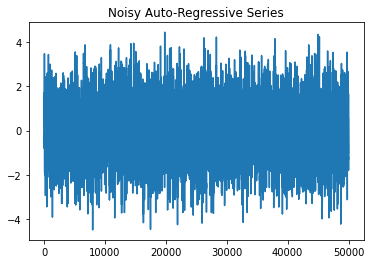

In [11]:
plt.plot(series)
plt.title("Noisy Auto-Regressive Series")
plt.show()
#print('May diverge if noise = 0 and PHIs large, be careful.')

* Our AR(p) series is ready and tested.
* Let's try it as input to a model verified from TF2 documentation:


* Now try write custom-Layers-based version of our model from AR1_TfKeras_CustomModel_v1.ipynb:

AR# ***5. New Variations on Custom Model and Custom Layer:***
# ***===================================***



ARMA(2,2)

* state: 
ht-1 = (yt-1, yt-2, et-1, et-2)

update: in t+=1

* yt = input
* yt^ = f1 yt-1 +  f2*yt-2 + b1*et-1 + b*2et-2
* et = yt - yt^
* et-1= 
* yt-1= 

(yt, yt-1, yt - yt^, et-1 )

one more update: in t+=1

(yt+1, yt, yt+1 - yt+1^, et ) = (h1 h2 h3 h4)

can i calc yt^ from ht-1? yes, done above

theta = (f1 f2 b1 b2)

logL = -(n/2)log(2pi sigma^2) - (1/2sigma^2)(y - theta^T * state)

* theta* = argmin -logL

* ht = (yt, yt-1, yt - yt^, et-1 )
* write ht as f(yt, ht-1)

* ht = f(yt, ht-1) = (yt, ht-1[1], yt - theta*ht-1, ht-1[3] )



In [12]:
class Linear4(layers.Layer):

  def __init__(self, units=P, **kwargs):
    super(Linear4, self).__init__(**kwargs)
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable=True)
    self.log_sigma = self.add_weight(shape=(self.units,),
                                     initializer='random_normal',
                                     trainable=True)
    self.state = tf.Variable(0.0) # Initialize state
    # self.built = True

  def call(self, inputs):
    self.state = tf.matmul(inputs, self.w) + self.b
    output = self.state
    log_sigma = self.log_sigma
    return output, log_sigma

In [13]:
# Build known model as CustomModel
# Later I can change the Layers to my CustomLayer

class CustomModel4(tf.keras.Model):

    def __init__(self, L1=None, L2=None):
        super(CustomModel4, self).__init__()
        self.layer1 = Linear4(1)
        self.log_sigma = tf.Variable(-0.3)
        # self.state = tf.Variable(0.0)

    def call(self, inputs):
        output, log_sigma = self.layer1(inputs)
        self.log_sigma = log_sigma
        return output

    def loss_mse(self, target_y, predicted_y):
        return tf.reduce_mean(tf.square(target_y - predicted_y))

    def loss_logL(self, target_y, predicted_y):#, sigma):
        sigma = tf.math.exp(self.log_sigma)
        sigma_sq = tf.math.square(sigma)
        msdiff = tf.reduce_mean(tf.square((target_y - predicted_y)))

        dlogL = self.log_sigma + 0.5*msdiff / sigma_sq
        return dlogL

In [14]:
# Declare my model:
modelayer4     = CustomModel4()

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
modelayer4.compile(optimizer, 
                    loss=modelayer4.loss_logL)

In [16]:
training_logs = modelayer4.fit( X_train, Y_train, epochs=100, verbose=1)

Epoch 1/100
782/782 [==============================] - 1s 1ms/step - loss: 0.3887
Epoch 2/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1348
Epoch 3/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1883
Epoch 4/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1883
Epoch 5/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1883
Epoch 6/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1882
Epoch 7/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1882
Epoch 8/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1882
Epoch 9/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1882
Epoch 10/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1883
Epoch 11/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1882
Epoch 12/100
782/782 [==============================] - 1s 1ms/step - loss: -0.1882
Ep

In [17]:
print('Phi estimated: ' + str( modelayer4.get_weights()[0][0][0] ))
print('Const estimated: ' + str( modelayer4.get_weights()[1][0] ))
print('logSigma estimated: ' + str( modelayer4.get_weights()[2][0] ))

Phi estimated: 0.9030032
Const estimated: 0.0044042496
logSigma estimated: -0.68835306


In [18]:
print('True Phi : ' + str( PHIs[0] ))
print('True Const : ' + str( CONST ))
print('True logSigma : ' + str( np.log(SIGMA) ))

True Phi : 0.9
True Const : 0
True logSigma : -0.6931471805599453
